# 라이브러리 임포트

In [ ]:
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import MNIST

# CUDA 설정

In [ ]:
if torch.cuda.is_available():
    cuda = torch.device('cuda')
else:
    cuda = torch.device('cpu')

print(cuda)

cuda


In [ ]:
torch.manual_seed(777)

# 노이즈 함수 정의

In [ ]:
import math
import numbers
import random
import warnings
from collections.abc import Sequence
from typing import Tuple, List, Optional

import torch
from torch import Tensor

class RandomErasing(torch.nn.Module):
    def __init__(self, p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False):
        super().__init__()
        if not isinstance(value, (numbers.Number, str, tuple, list)):
              raise TypeError("Argument value should be either a number or str or a sequence")
        if isinstance(value, str) and value != "random":
              raise ValueError("If value is str, it should be 'random'")
        if not isinstance(scale, (tuple, list)):
              raise TypeError("Scale should be a sequence")
        if not isinstance(ratio, (tuple, list)):
              raise TypeError("Ratio should be a sequence")
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
              warnings.warn("Scale and ratio should be of kind (min, max)")
        if scale[0] < 0 or scale[1] > 1:
              raise ValueError("Scale should be between 0 and 1")
        if p < 0 or p > 1:
              raise ValueError("Random erasing probability should be between 0 and 1")

        self.p = p
        self.scale = scale
        self.ratio = ratio
        self.value = value
        self.inplace = inplace


    def get_params(
            self, img: Tensor, scale: Tuple[float, float], ratio: Tuple[float, float], value: Optional[List[float]] = None
    ) -> Tuple[int, int, int, int, Tensor]:

        img_c, img_h, img_w = img.shape[-3], img.shape[-2], img.shape[-1]
        area = img_h * img_w

        log_ratio = torch.log(torch.tensor(ratio))
        for _ in range(10):
            erase_area = area * torch.empty(1).uniform_(scale[0], scale[1]).item()
            aspect_ratio = torch.exp(
                torch.empty(1).uniform_(log_ratio[0], log_ratio[1])
            ).item()

            h = int(round(math.sqrt(erase_area * aspect_ratio)))
            w = int(round(math.sqrt(erase_area / aspect_ratio)))
            if not (h < img_h and w < img_w):
                continue

            if value is None:
                v = torch.empty([img_c, h, w], dtype=torch.float32).normal_()
            else:
                v = torch.tensor(value)[:, None, None]

            i = torch.randint(0, img_h - h + 1, size=(1, )).item()
            j = torch.randint(0, img_w - w + 1, size=(1, )).item()
            return i, j, h, w, v

        # Return original image
        return 0, 0, img_h, img_w, img


#[docs]    
    def forward(self, img):
        """
        Args:
            img (Tensor): Tensor image to be erased.

        Returns:
            img (Tensor): Erased Tensor image.
        """
        if torch.rand(1) < self.p:

            # cast self.value to script acceptable type
            if isinstance(self.value, (int, float)):
                value = [self.value, ]
            elif isinstance(self.value, str):
                value = None
            elif isinstance(self.value, tuple):
                value = list(self.value)
            else:
                value = self.value

            if value is not None and not (len(value) in (1, img.shape[-3])):
                raise ValueError(
                    "If value is a sequence, it should have either a single value or "
                    "{} (number of input channels)".format(img.shape[-3])
                )

            x, y, h, w, v = self.get_params(img, scale=self.scale, ratio=self.ratio, value=value)
            return transforms.functional.erase(img, x, y, h, w, v, self.inplace)
        return img

In [ ]:
def add_noise(img):
    noise = torch.randn(img.size())*0.2
    noisy_img = img+noise
    return noisy_img

# 노이즈 시각화

6


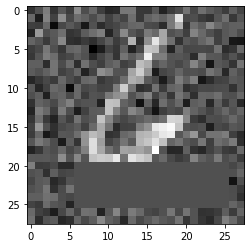

In [ ]:
e = RandomErasing()
idx = np.random.randint(0, 60000)
origin, label = train_load.dataset[idx]
noisy_data = add_noise(origin)
noisy_data = e(noisy_data)
print(label)
plt.imshow(noisy_data.squeeze(),cmap="gray")

# 데이터 로드

In [ ]:
train_trans = transforms.Compose([
    transforms.ToTensor(),
])

test_trans = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
train_data = MNIST(root='./data', download=True, train=True, transform=train_trans)
test_data = MNIST(root='./data', download=True, train=False, transform=test_trans)

In [ ]:
batch_size = 128
train_load = DataLoader(train_data, batch_size, num_workers=4, shuffle=True)
test_load = DataLoader(test_data, batch_size, num_workers=4, shuffle=True)

# DAE 모델 정의

## DNN_DAE

In [ ]:
# 층이 많은 DAE
class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
             nn.ReLU(),
             nn.Linear(128, 64),
             nn.ReLU(),
             nn.Linear(64, 32),
             nn.ReLU(),
             nn.Linear(32, 3)
        )
        self.Decoder = nn.Sequential(
             nn.Linear(3, 32),
             nn.ReLU(),
             nn.Linear(32, 64),
             nn.ReLU(),
             nn.Linear(64, 128),
             nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x=self.Encoder(x)
        x=self.Decoder(x)
        
        return x

In [ ]:
# 층이 적은 DAE
class min_DAE(nn.Module):
    def __init__(self):
        super(min_DAE, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.Decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x=self.Encoder(x)
        x=self.Decoder(x)
        
        return x

## CNN_DAE

In [ ]:
class cnn_DAE(nn.Module):
    def __init__(self):
        super(cnn_DAE, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 7, 1),
        )
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 7, 1), # stride를 크게 줄수록 output size 증가
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, 2, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x=self.Encoder(x)
        x=self.Decoder(x)
        
        return x

In [ ]:
class cnn_DAE2(nn.Module):
    def __init__(self):
        super(cnn_DAE2, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 1), # output 16*26*26
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Conv2d(16, 32, 7, 1, 1), # output 32 * 22*22
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32*22*22, 512),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 7, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 5, 1, 1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.fc2  = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(512, 32*22*22),
            nn.ReLU()
        )
        
    def forward(self, x):
        x=self.Encoder(x)
        x=x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), 32, 22, 22)
        x=self.Decoder(x)
        
        return x

In [ ]:
class cnn_DAE3(nn.Module):
    def __init__(self):
        super(cnn_DAE3, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), # output 16*28*28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.5),# 0.7에 에폭 20
            nn.Conv2d(16, 32, 5, 1), # output 16*26*26
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(32, 64, 7, 1), # output 32 * 22*22
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(64*22*22, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, 1, 1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.fc2  = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 64*22*22),
            nn.ReLU()
        )
        
    def forward(self, x):
        x=self.Encoder(x)
        x=x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), 64, 22, 22)
        x=self.Decoder(x)
        
        return x

In [ ]:
class cnn_DAE4(nn.Module):
    def __init__(self):
        super(cnn_DAE4, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, 8, 5, 2, 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 7, 1, 1),
        )
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 7, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 5, 2, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x=self.Encoder(x)
        x=self.Decoder(x)
        
        return x

# 모델 평가함수 정의

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    e = RandomErasing() # erasion 적용을 위해 사용
    val_loss = 0
    
    loss_= []
    
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, label = sample
            noisy_data = add_noise(data)
            noisy_data = e(noisy_data)
            noisy_data = noisy_data.view(-1, 28*28)
            noisy_data = noisy_data.to(cuda)

            label = data.view(-1, 28*28)
            label = label.to(cuda)

            out = model(noisy_data)

            loss = criterion(out, label)
            val_loss += loss.item()

        val_loss /= len(test_loader.dataset) 


    return val_loss

# 모델 학습 설정 및 객체화

In [ ]:
criterion = nn.MSELoss().to(cuda)
model = DAE()
model = model.to(cuda)

opt = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt,step_size = 10, gamma = 0.8) 

# 모델 학습 및 평가

In [ ]:
train_loss = [] # train loss 값의 추이를 보기 위해 설정

test_loss = [] # test loss 값의 추이를 보기 위해 설정

e = RandomErasing() # erasion 적용을 위해 사용

for epoch in range(50):
    model.train()

    loss_ = 0
    
    loss_test = 0

    for batch, train in enumerate(train_load):
        data, label = train
        noisy_data = add_noise(data) # 노이즈 추가
        noisy_data = e(noisy_data)
        noisy_data = noisy_data.view(-1, 28*28) # MLP이기 때문에 차원 변경
        noisy_data = noisy_data.to(cuda)
        
        label = data.view(-1, 28*28) # 라벨의 차원 변경
        label = label.to(cuda)

        out = model(noisy_data)

        loss = criterion(out, label)

        loss_ += loss.item()

        opt.zero_grad()
        loss.backward()
        opt.step()

        
    epoch_loss = loss_ / len(train_load.dataset)
    
    train_loss.append(epoch_loss)
    
    loss_test = evaluate(model, test_load)
    print(f'epoch : {epoch+1}\t Loss : {epoch_loss:.6f}\t Test Loss : {loss_test:.6f}')
    
    test_loss.append(loss_test)

    scheduler.step()


epoch : 1	 Loss : 0.000403	 Test Loss : 0.000279
epoch : 2	 Loss : 0.000252	 Test Loss : 0.000218
epoch : 3	 Loss : 0.000218	 Test Loss : 0.000213
epoch : 4	 Loss : 0.000196	 Test Loss : 0.000192
epoch : 5	 Loss : 0.000187	 Test Loss : 0.000178
epoch : 6	 Loss : 0.000178	 Test Loss : 0.000182
epoch : 7	 Loss : 0.000175	 Test Loss : 0.000177
epoch : 8	 Loss : 0.000168	 Test Loss : 0.000178
epoch : 9	 Loss : 0.000165	 Test Loss : 0.000179
epoch : 10	 Loss : 0.000161	 Test Loss : 0.000164
epoch : 11	 Loss : 0.000159	 Test Loss : 0.000164
epoch : 12	 Loss : 0.000155	 Test Loss : 0.000161
epoch : 13	 Loss : 0.000155	 Test Loss : 0.000155
epoch : 14	 Loss : 0.000160	 Test Loss : 0.000162
epoch : 15	 Loss : 0.000159	 Test Loss : 0.000155
epoch : 16	 Loss : 0.000148	 Test Loss : 0.000154
epoch : 17	 Loss : 0.000148	 Test Loss : 0.000159
epoch : 18	 Loss : 0.000150	 Test Loss : 0.000141
epoch : 19	 Loss : 0.000144	 Test Loss : 0.000144
epoch : 20	 Loss : 0.000151	 Test Loss : 0.000154
epoch : 2

# 학습 결과 시각화

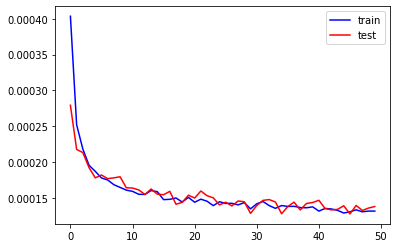

In [ ]:
plt.plot(train_loss, 'b', label='train')
plt.plot(test_loss, 'r', label='test')
plt.legend()
plt.show()

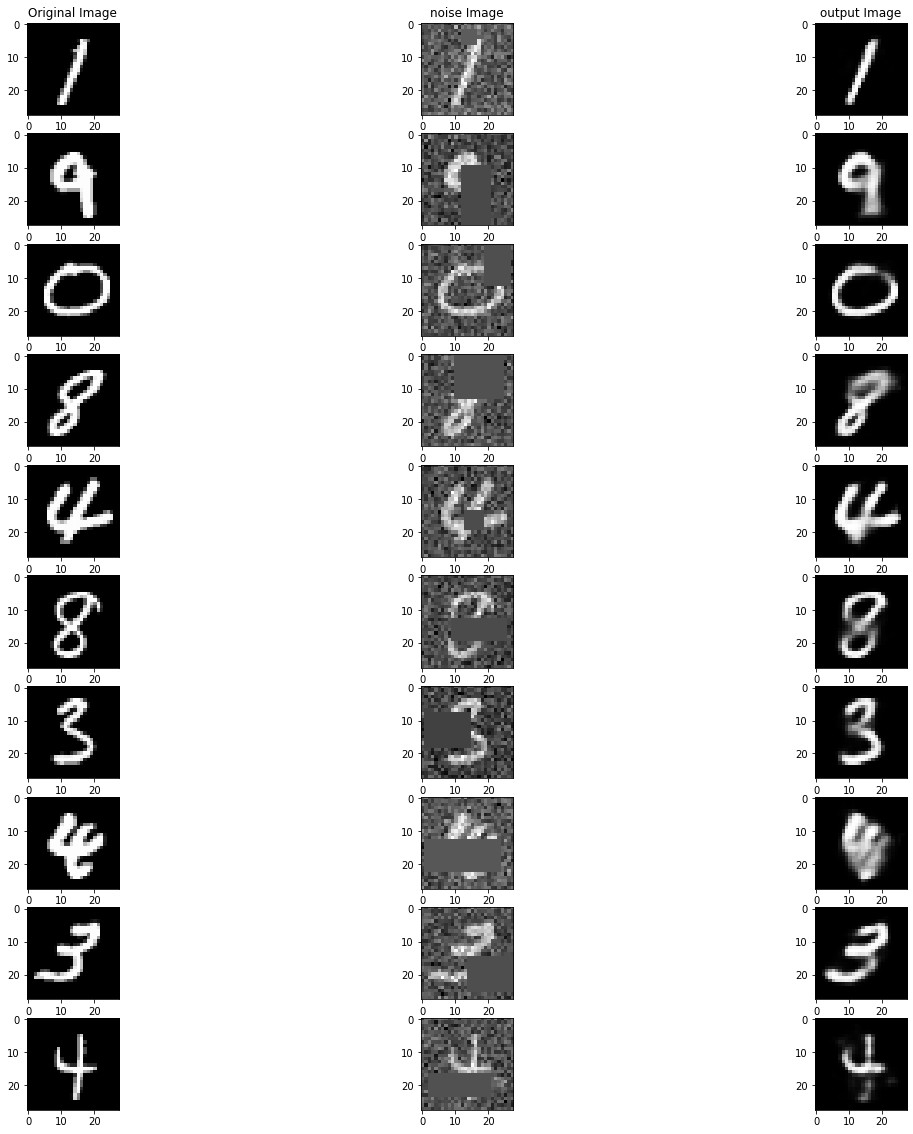

In [ ]:
test_data = []

e = RandomErasing() # erasion 적용을 위해 사용

f,axes= plt.subplots(10,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("noise Image")
axes[0,2].set_title("output Image")

for i in range(10):
    idx = np.random.randint(0, 10000)
    origin = test_load.dataset[idx][0]
    noisy_data = add_noise(origin)
    noisy_data = e(noisy_data)
    input_data = noisy_data.view(-1, 28*28).to(cuda)
    out = model(input_data)
    out = np.reshape(out.to("cpu").data.numpy(), (28, 28))
    
    axes[i,0].imshow(origin.squeeze(),cmap="gray")
    axes[i,1].imshow(noisy_data.squeeze(),cmap="gray")
    axes[i,2].imshow(out,cmap="gray")
    